## MGMTMFE 405-2 Computational Methods in Finance
### Project 6 - Exotic Option Valuations and the Simulation of Jump-Diffusions
#### February 22, 2019
#### Hyeuk Jung (005259560)

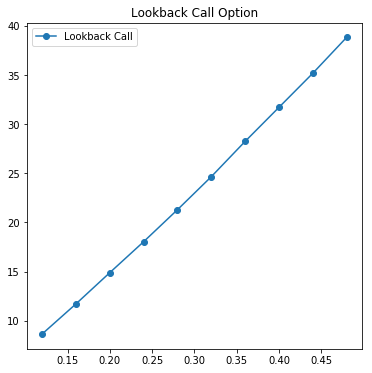

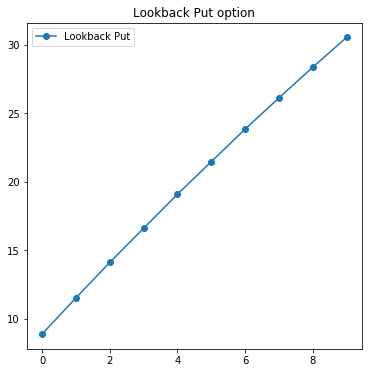

     sd  Lookback Call  Lookback Put
0  0.12       8.658275      8.889143
1  0.16      11.719847     11.529164
2  0.20      14.896995     14.112570
3  0.24      18.042543     16.604677
4  0.28      21.297477     19.081357
5  0.32      24.654529     21.459671
6  0.36      28.243889     23.831447
7  0.40      31.705872     26.112242
8  0.44      35.169804     28.349493
9  0.48      38.820107     30.522486


In [5]:
#
# Jung_Hyeuk_Project6.py
# MGMTMFE405-2 Computational Methods in Finance - Project 6
# Hyeuk Jung (005259560)
#

import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(int(time.time()))

#start = time.time()

# 1. Fixed Strike Lookback Call and Put
def stockPrice(S0, T, r, sd, n, step):
    # Stock prices: Generate 50,000 paths and 50,000 antithetic variates paths
    dt = T/step
    stocks = np.zeros((2*n, step+1))
    stocks[:, 0] = S0
    z = np.random.normal(0, 1, n*step).reshape(n, step)
    w = np.sqrt(dt)*z
    w_anti = np.sqrt(dt)*(-1)*z
    W = np.concatenate((w, w_anti), axis=0)
    
    for i in range(1, step+1, 1):
        stocks[:, i] = stocks[:, i-1]*np.exp((r-sd*sd/2)*dt + sd*W[:, i-1])
    
    return stocks

def lookback(type, S0, T, K, r, sd, npath, step): # n: number of paths
    dt = T/step
    # Stock price paths
    stocks = stockPrice(S0, T, r, sd, npath, step) # returns 2*npath paths

    # Fixed Strike Lookback Call
    if type == "C":
        # Maximum stock prices for each row
        maxS = np.amax(stocks, axis=1) # returns maximum values for each row
        option = np.maximum(np.transpose(maxS) - K, 0)
        value = np.mean( np.exp(-1*r*T)*option )

    # Fixed Strike Lookback Put
    if type == "P":
        # Minimum stock prices for each row
        minS = np.amin(stocks, axis=1) # returns minimum values for each row        
        option = np.maximum(K- np.transpose(minS), 0)
        value = np.mean( np.exp(-1*r*T)*option )

    return value


S0 = 98; K = 100; r = 0.03; SD = np.arange(0.12, 0.48+0.04, 0.04); T = 1 # 1 year
npath = 50000; step = 100

# 1. (a) Lookback call
result_lookbackcall = dict()
for sd in SD:
    result_lookbackcall[(sd)] = lookback("C", S0, T, K, r, sd, npath, step)
    # 2*50000: number of simulation paths # 100: number of steps in the path

# 1. (b) Lookback put
result_lookbackput = dict()
for sd in SD:
    result_lookbackput[(sd)] = lookback("P", S0, T, K, r, sd, npath, step)
    # 2*50000: number of simulation paths # 100: number of steps in the path

combined = pd.concat([pd.DataFrame(list(result_lookbackcall.keys())), pd.DataFrame(list(result_lookbackcall.values())), pd.DataFrame(list(result_lookbackput.values()))], axis=1)
combined.columns = ['sd', 'Lookback Call', 'Lookback Put']

plt.figure(figsize=(6,6))
plt.plot(SD, combined['Lookback Call'], label = 'Lookback Call', marker='o')
plt.legend(); plt.title('Lookback Call Option')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(combined['Lookback Put'], label = 'Lookback Put', marker='o')
plt.legend(); plt.title('Lookback Put option')
plt.show()

print(combined)



In [2]:
# 2. Jump Diffusion Process
def collateralValue(V0, T, mu, sd, gamma, lambda_1, npath):
    n = T*12 # number of steps in each path
    dt = T/n
    value = np.zeros((npath, n+1))
    value[:, 0] = V0
    z = np.random.normal(0, 1, npath*n).reshape(npath, n)
    W = np.sqrt(dt)*z

    for i in range(1, n+1, 1):
        # apply jump diffusion: jump size = gamma < 0, # of jumps ~ Poisson(lambda_1*dt) as it depends on time
        # Set the range for poisson random variables to be 0 or 1
        value[:, i] = value[:, i-1]*np.exp((mu-sd*sd/2)*dt + sd*W[:, i-1]) * (1 + gamma*np.clip(np.random.poisson(lambda_1*dt, npath), a_max=1, a_min=0))

    return value

def collateralizedLoan(r, T, L0): # r = R/12
    n = T*12
    dt = T/n
    PMT = L0*r / ( 1 - 1/(1+r)**n )
    a = PMT / r
    b = PMT / ( r*(1+r)**n )
    c = 1+r
    Lt = [ a - b*(c**(12*dt*t)) for t in np.arange(0, n+1, 1) ]

    return Lt # L0 ~ LT

def stoppingTime_1(alpha, epsilon, T, r, V, L, npath): #npath, n
    # V: entire value matrix, L: collateralized loan value for each time period
    n = T*12
    dt = T/n
    beta = (epsilon - alpha) / T

    # recovery rate
    qt = [ (alpha + beta*dt*t) for t in np.arange(0, n+1, 1) ]
    # threshold matrix 
    threshold = np.tile(np.multiply(qt,L), (npath, 1)) 

    Q = np.where(V <= threshold, 1, 0) # index for default cases
    # earliest default point for each path
    # if there is 1 in the row, return the first 1's index or return n+1 implying no default
    Q_time = np.where(Q.any(axis=1), Q.argmax(axis=1), n+1)

    return Q_time 

def stoppingTime_2(lambda_2, npath, T): 
    # earliest default point for each path
    n = T*12 # number of steps in each path
    dt = T/n
    Nt = np.zeros((npath, n+1))

    for i in range(0, npath, 1):
        Nt[i, :] = np.clip(np.random.poisson(lambda_2*dt, n+1), a_max=1, a_min=0)
    #for i in range(0, n+1, 1): S_bycol[:, i] = np.random.poisson(lambda_2*dt, npath)

    # if there is 1 in the row, return the first 1's index or return n+1 implying no default
    S_time = np.where(Nt.any(axis=1), Nt.argmax(axis=1), n+1)

    return S_time

def Proj6_2function(V0, L0, mu, sd, T, r0, delta, gamma, lambda_1, lambda_2, alpha, epsilon, npath):
    
    n = T*12
    dt = T/n
    R = r0 + delta*lambda_2
    r = R/12

    collateral_value = collateralValue(V0, T, mu, sd, gamma, lambda_1, npath) # V
    collateralized_loan = collateralizedLoan(r, T, L0) # Lt
    
    Q = stoppingTime_1(alpha, epsilon, T, r, collateral_value, collateralized_loan, npath)
    S = stoppingTime_2(lambda_2, npath, T)
    tau = np.minimum(Q, S) # tau < T --> default #print('tau:', tau)
    
    # payoff
    default_time = np.where(Q <= S, 1, 0) # default at time Q -> set 1, S or no default -> 0
    no_default = np.where(tau == n+1) # no default paths' row indices
    default_time[no_default] = n+1 # no default -> n+1
    #print('default_time (1=Q, 0=S):', default_time)

    payoff = np.zeros(npath) # no default -> payoff = 0
    # at time Q
    default_Q = np.where(default_time == 1)
    payoff[default_Q] = np.maximum( np.array(collateralized_loan)[tau[default_Q]] - epsilon*collateral_value[default_Q, tau[default_Q]], 0 )
    # at time S
    default_S = np.where(default_time == 0)
    payoff[default_S] = np.abs( np.array(collateralized_loan)[tau[default_S]] - epsilon*collateral_value[default_S, tau[default_S]] )
    #print(payoff)

    # discount 
    discount = np.exp(-1*r0*dt * tau)
    value = np.mean(discount*payoff) #print('option value:', value)

    # default probability
    #print(np.where(payoff == 0))
    default_prob = 1 - len(payoff[np.where(payoff == 0)]) / npath #print('default probability:', default_prob)

    # expected exercise time
    expected_time = np.mean( tau[np.where(default_time != n+1)] * dt )
    #print('expected exercise time:', expected_time,'/ 5')

    result = [value, default_prob, expected_time]
    #columns=['Default Option Value', 'Default Probatility', 'Expected Exercise Time'])

    return result


V0 = 20000; L0 = 22000; mu = -0.1; sd = 0.2; T = 5; r0 = 0.02; delta = 0.25
gamma = -0.4; lambda_1 = 0.2; lambda_2 = 0.4; alpha = 0.7; epsilon = 0.95
npath = 50000
LAMBDA1 = np.arange(0.05, 0.4 + 0.05, 0.05)
LAMBDA2 = np.arange(0, 0.8+0.1, 0.1)
TIME = np.arange(3, 8+1, 1)


In [3]:
# Result for the default setting
result = Proj6_2function(V0, L0, mu, sd, T, r0, delta, gamma, lambda_1, lambda_2, alpha, epsilon, npath)
df_result = pd.DataFrame(result, columns=['Results'])
df_result.index = ['Default Option Value', 'Default Probatility', 'Expected Exercise Time']
print(df_result)


                            Results
Default Option Value    4671.983812
Default Probatility        0.950500
Expected Exercise Time     1.163951


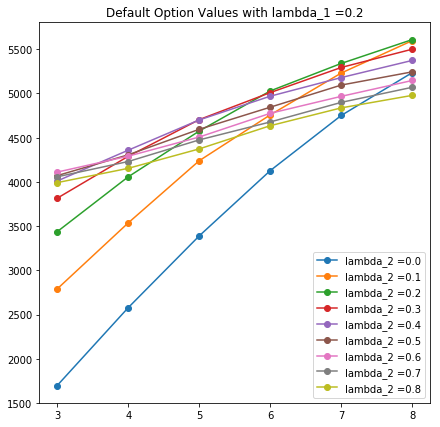

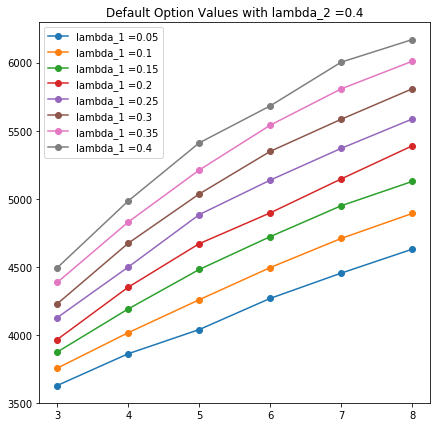

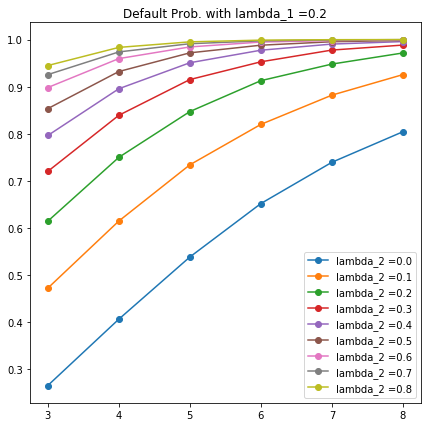

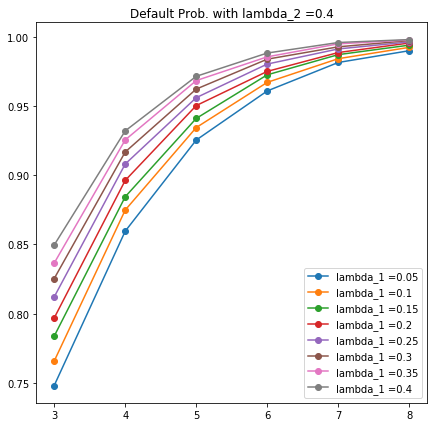

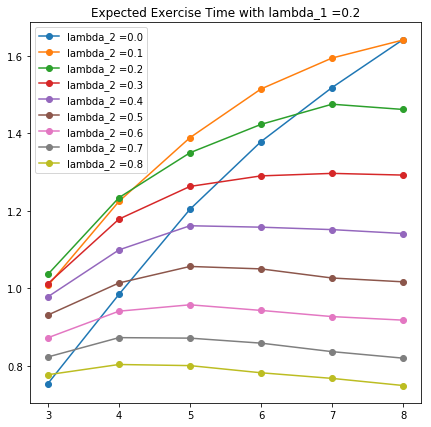

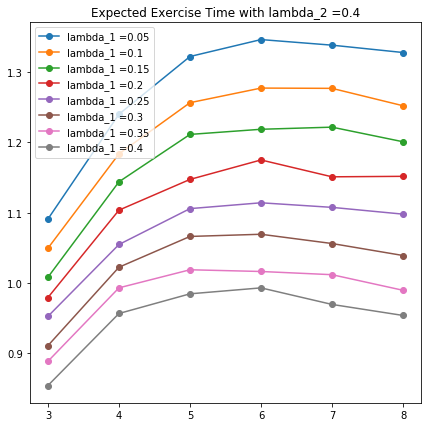

Result with fixed lambda_1 = 0.2 
     lambda_2  T  Option value  Default prob  Exercise time
0        0.0  3   1698.315114       0.26592       0.754550
1        0.0  4   2577.979481       0.40666       0.984672
2        0.0  5   3389.385365       0.53858       1.204228
3        0.0  6   4126.915509       0.65200       1.378824
4        0.0  7   4750.632858       0.73954       1.518322
5        0.0  8   5234.846003       0.80436       1.642113
6        0.1  3   2789.707730       0.47252       1.007552
7        0.1  4   3536.010849       0.61488       1.224556
8        0.1  5   4238.794746       0.73418       1.389060
9        0.1  6   4756.943520       0.81996       1.514710
10       0.1  7   5229.968695       0.88198       1.594469
11       0.1  8   5596.146735       0.92556       1.641025
12       0.2  3   3436.936028       0.61460       1.036495
13       0.2  4   4056.895504       0.75002       1.234229
14       0.2  5   4574.160950       0.84718       1.350091
15       0.2  6   502

In [4]:
# with lambda_1 = 0.2
lambda_1 = 0.2
result_02 = dict()
for l2 in LAMBDA2:
    for time in TIME:
        result_02[(l2, time)] = Proj6_2function(V0, L0, mu, sd, time, r0, delta, gamma, lambda_1, l2, alpha, epsilon, npath)
df_result_02 = pd.concat([pd.DataFrame(list(result_02.keys())), pd.DataFrame(list(result_02.values()))], axis=1)
df_result_02.columns = ['lambda_2', 'T', 'Option value', 'Default prob', 'Exercise time'] # print(df_result_02)

# with lambda_2 = 0.4
lambda_2 = 0.4
result_04 = dict()
for l1 in LAMBDA1:
    for time in TIME:
        result_04[(l1, time)] = Proj6_2function(V0, L0, mu, sd, time, r0, delta, gamma, l1, lambda_2, alpha, epsilon, npath)
df_result_04 = pd.concat([pd.DataFrame(list(result_04.keys())), pd.DataFrame(list(result_04.values()))], axis=1)
df_result_04.columns = ['lambda_1', 'T', 'Option value', 'Default prob', 'Exercise time'] # print(df_result_02)


# 2 (a) Default option value
plt.figure(figsize=(7,7))
for l2 in LAMBDA2:
    row = df_result_02.index[df_result_02['lambda_2'] == l2].tolist()
    plt.plot(TIME, df_result_02.loc[row, 'Option value'], 
    label = 'lambda_2 =' + str(round(l2, 2)), marker='o' )
plt.legend()
plt.title('Default Option Values with lambda_1 =' + str(lambda_1))
plt.show()

plt.figure(figsize=(7,7))
for l1 in LAMBDA1:
    row = df_result_04.index[df_result_04['lambda_1'] == l1].tolist()
    plt.plot(TIME, df_result_04.loc[row, 'Option value'], 
    label = 'lambda_1 =' + str(round(l1, 2)), marker='o' )
plt.legend()
plt.title('Default Option Values with lambda_2 =' + str(lambda_2))
plt.show()

# 2 (b) Default probability
plt.figure(figsize=(7,7))
for l2 in LAMBDA2:
    row = df_result_02.index[df_result_02['lambda_2'] == l2].tolist()
    plt.plot(TIME, df_result_02.loc[row, 'Default prob'], 
    label = 'lambda_2 =' + str(round(l2, 2)), marker='o' )
plt.legend()
plt.title('Default Prob. with lambda_1 =' + str(lambda_1))
plt.show()

plt.figure(figsize=(7,7))
for l1 in LAMBDA1:
    row = df_result_04.index[df_result_04['lambda_1'] == l1].tolist()
    plt.plot(TIME, df_result_04.loc[row, 'Default prob'], 
    label = 'lambda_1 =' + str(round(l1, 2)), marker='o' )
plt.legend()
plt.title('Default Prob. with lambda_2 =' + str(lambda_2))
plt.show()

# 2 (c) Expected exercise time
plt.figure(figsize=(7,7))
for l2 in LAMBDA2:
    row = df_result_02.index[df_result_02['lambda_2'] == l2].tolist()
    plt.plot(TIME, df_result_02.loc[row, 'Exercise time'], 
    label = 'lambda_2 =' + str(round(l2, 2)), marker='o' )
plt.legend()
plt.title('Expected Exercise Time with lambda_1 =' + str(lambda_1))
plt.show()

plt.figure(figsize=(7,7))
for l1 in LAMBDA1:
    row = df_result_04.index[df_result_04['lambda_1'] == l1].tolist()
    plt.plot(TIME, df_result_04.loc[row, 'Exercise time'], 
    label = 'lambda_1 =' + str(round(l1, 2)), marker='o' )
plt.legend()
plt.title('Expected Exercise Time with lambda_2 =' + str(lambda_2))
plt.show()

print('Result with fixed lambda_1 =', lambda_1,'\n', df_result_02)
print('Result with fixed lambda_2 =', lambda_2,'\n', df_result_04)

#total_execution = time.time() - start
#print('Total execution time:', total_execution)

